# Student Performance Classification - Real Data Project
## Multiclass Classification Using Real Student Data

**Project Goal:** Predict student performance level (Low/Medium/High) based on study habits, attendance, and background factors using real data from UCI Machine Learning Repository.

**Dataset:** Student Performance (Portuguese Language Course) - https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip

**Models:** Naive Bayes, Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost

## 1. IMPORTS AND SETUP

In [96]:
# Setup:

# data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb

# metrics and evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model saving
import joblib
import os

# warnings
import warnings
warnings.filterwarnings('ignore')

# set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("impoted")

impoted


## 2. LOAD AND EXPLORE REAL DATA

In [97]:
# Data loading

# download from repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'

try:
    import urllib.request
    import zipfile

    print("downloading dataset")
    urllib.request.urlretrieve(url, 'student.zip')

    with zipfile.ZipFile('student.zip', 'r') as zip_ref:
        zip_ref.extractall()

    # Load Portuguese course data
    df = pd.read_csv('student-por.csv', sep=';')
    print(f"dataset downloaded\n")

except Exception as e:
    print(f"Download failed, trying another dataset\n")
    # Alternative: Load from direct source
    df = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/student-por.csv', sep=';')
    print(f"dataset loaded from alternative source\n")

print(f"dataset Shape: {df.shape}")
print(f"rows: {df.shape[0]} students")
print(f"columns: {df.shape[1]} features")
print(f"\nfirst  rows:")
print(df.head())
print(f"\ncolumn names:")
print(df.columns.tolist())

downloading dataset
dataset downloaded

dataset Shape: (649, 33)
rows: 649 students
columns: 33 features

first  rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  1

## 3. EXPLORATORY DATA ANALYSIS (EDA)

In [98]:
# EDA
print("dataset info:")
print(f"\nshape: {df.shape}")
print(f"\ndata types:")
print(df.dtypes)
print(f"\nmissing values:")
print(df.isnull().sum())
print(f"\nbasic statistics:")
print(df.describe())

dataset info:

shape: (649, 33)

data types:
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

missing values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failure


original grade column (G3 - final grade):
count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

performance distribution:
performance
Medium    418
High      131
Low       100
Name: count, dtype: int64

performance distribution (%):
performance
Medium    64.40678
High      20.18490
Low       15.40832
Name: proportion, dtype: float64


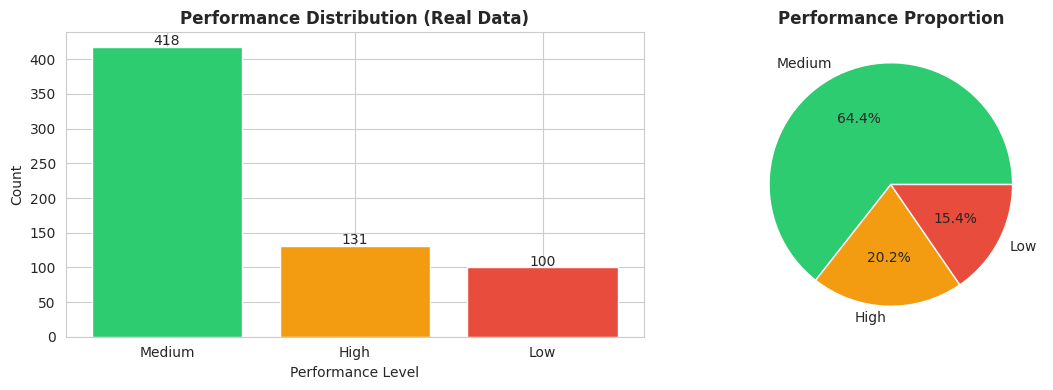


 target variable created successfully


In [99]:
# Create target variable
print(f"\noriginal grade column (G3 - final grade):")
print(df['G3'].describe())

# create performance categories based on final grade (G3)
# G3 is the final grade on scale 0-20

def categorize_performance(grade):
    if grade >= 15:
        return 'High'      # excellent: 15-20
    elif grade >= 10:
        return 'Medium'    # good: 10-14
    else:
        return 'Low'       # satisfactory: 0-9

df['performance'] = df['G3'].apply(categorize_performance)

print(f"\nperformance distribution:")
print(df['performance'].value_counts())
print(f"\nperformance distribution (%):")
print(df['performance'].value_counts(normalize=True) * 100)

# visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# count plot
perf_counts = df['performance'].value_counts()
axes[0].bar(perf_counts.index, perf_counts.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_title('Performance Distribution (Real Data)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Performance Level')
for i, v in enumerate(perf_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center')

# Pie chart
axes[1].pie(perf_counts.values, labels=perf_counts.index, autopct='%1.1f%%',
             colors=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1].set_title('Performance Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n target variable created successfully")

In [100]:
# Analyze key features
print("\n=== KEY FEATURES ANALYSIS ===")


# numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('G3')  # Remove target
numeric_cols = [col for col in numeric_cols if col != 'performance']

print(f"numeric features: {len(numeric_cols)}")
print(numeric_cols)


=== KEY FEATURES ANALYSIS ===
numeric features: 15
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


correlation with performance

top correlations with performance:
health        0.107233
Dalc          0.080296
absences      0.058397
traveltime    0.058287
Walc          0.051386
goout         0.006397
failures     -0.002190
freetime     -0.003165
famrel       -0.024209
Fedu         -0.069538
dtype: float64


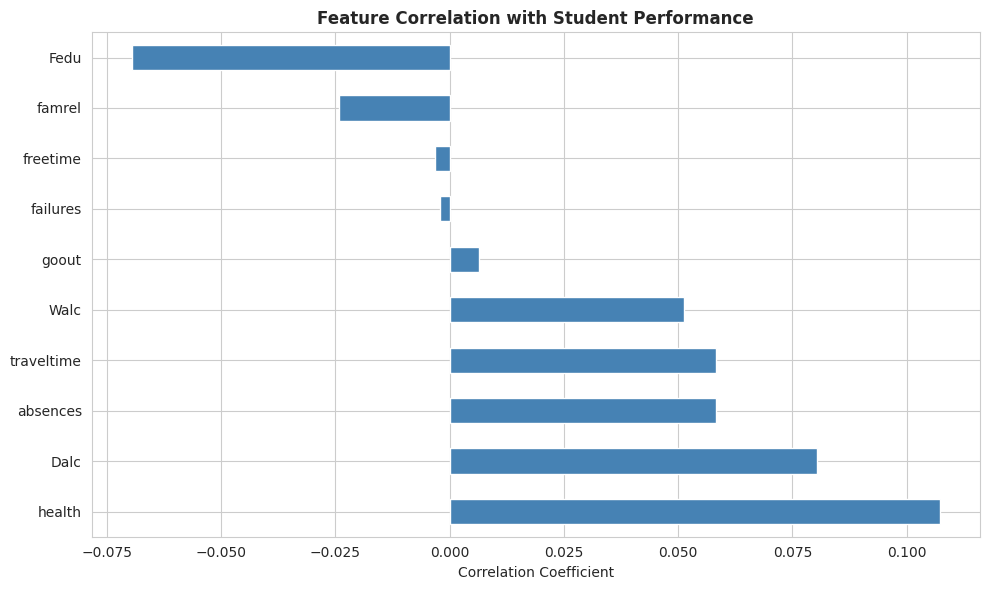

In [101]:
# correlation analysis
print("correlation with performance")
# encode target for correlation
le_temp = LabelEncoder()
performance_encoded = le_temp.fit_transform(df['performance'])

# calculate correlations
numeric_cols_list = list(numeric_cols)
correlation = df[numeric_cols_list].corrwith(pd.Series(performance_encoded)).sort_values(ascending=False)

print("\ntop correlations with performance:")
print(correlation.head(10))

# visualize
plt.figure(figsize=(10, 6))
correlation.head(10).plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Student Performance', fontsize=12, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

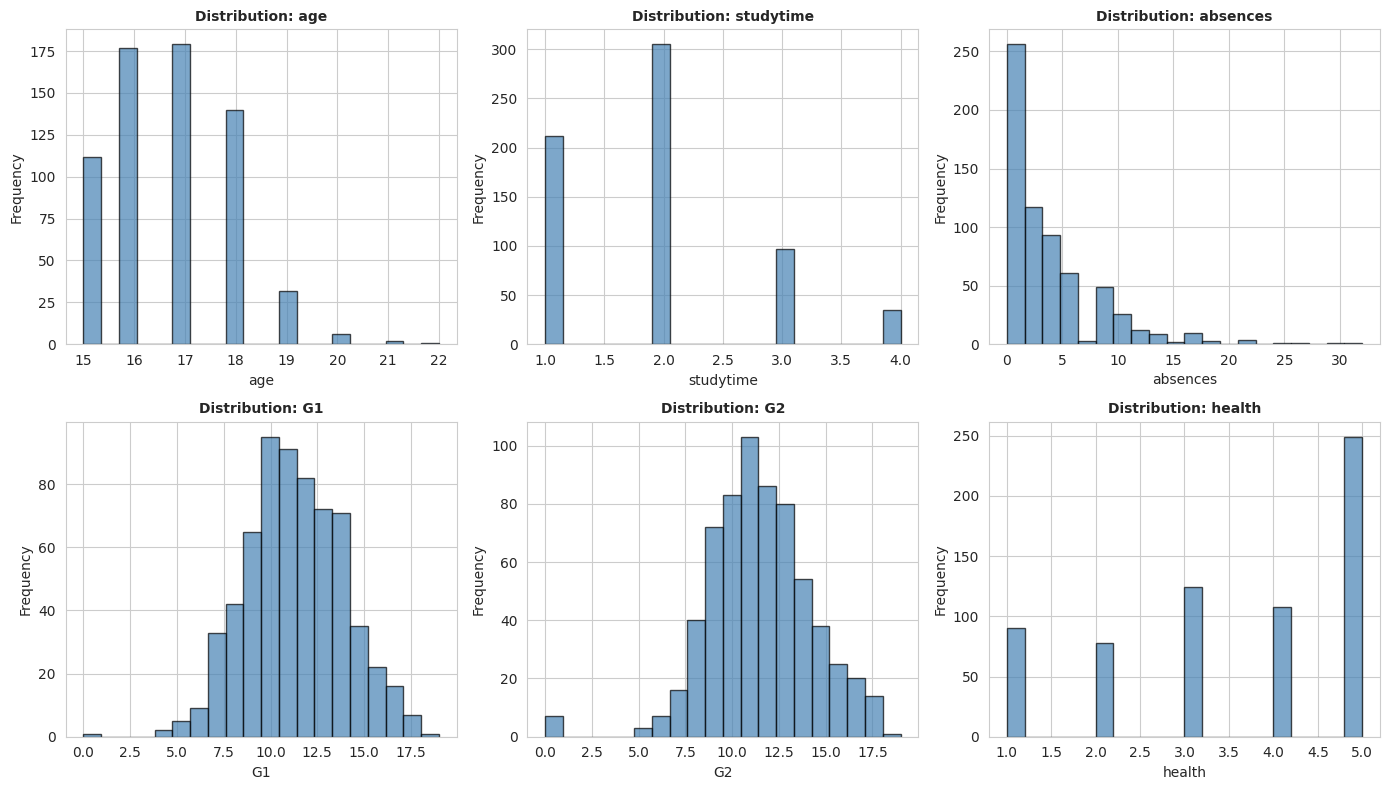

In [115]:
# Visualize distribution

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

# FIX: Use lowercase for all features except G1, G2 (they're uppercase in UCI dataset)
features_to_plot = ['age', 'studytime', 'absences', 'G1', 'G2', 'health']

for idx, feature in enumerate(features_to_plot):
    if feature in df.columns:
        axes[idx].hist(df[feature], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution: {feature}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
    else:
        # Show which columns don't exist
        print(f"⚠️ Column '{feature}' not found in dataframe")

plt.tight_layout()
plt.show()

## 4. DATA PREPROCESSING

In [103]:
# Preprocessing
print("\n=== DATA PREPROCESSING ===")

# create copy for preprocessing
df_processed = df.copy()

# drop target and unnecessary columns
print("\n dropping unnecessary columns...")
df_processed = df_processed.drop(['G3', 'performance'], axis=1)  # Will add performance back
print(f"shape after dropping: {df_processed.shape}")

# handle missing values
print("\n handling missing values...")
print(f"missing values: {df_processed.isnull().sum().sum()}")
df_processed = df_processed.fillna(df_processed.median(numeric_only=True))
df_processed = df_processed.fillna('Unknown')
print(f"after handling: {df_processed.isnull().sum().sum()}")

# identify categorical and numeric columns
print("\n identifying feature types...")
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()

print(f"categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"numeric columns ({len(numeric_cols)}): {numeric_cols[:5]}...")


=== DATA PREPROCESSING ===

 dropping unnecessary columns...
shape after dropping: (649, 32)

 handling missing values...
missing values: 0
after handling: 0

 identifying feature types...
categorical columns (17): ['school', 'sex', 'address', 'famsize', 'Pstatus']...
numeric columns (15): ['age', 'Medu', 'Fedu', 'traveltime', 'studytime']...


In [104]:
# encoding categorical features
print("\n encoding categorical features...")

# one-hot encode categorical features
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"shape after encoding: {df_encoded.shape}")
print(f"new features: {df_encoded.shape[1] - len(numeric_cols)}")

# add target variable back
df_encoded['performance'] = df['performance']

print(f"\n final dataset shape: {df_encoded.shape}")
print(f"features after encoding: {df_encoded.shape[1] - 1}")


 encoding categorical features...
shape after encoding: (649, 41)
new features: 26

 final dataset shape: (649, 42)
features after encoding: 41


In [105]:
# Split
print("\ splitting data")

# separate features and target
X = df_encoded.drop('performance', axis=1)
y = df_encoded['performance']

# encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"classes: {le.classes_}")
print(f"features: {X.shape[1]}")
print(f"samples: {X.shape[0]}")

# train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# check class distribution
print(f"\nclass distribution in training set:")
for i, cls in enumerate(le.classes_):
    count = (y_train == i).sum()
    pct = count / len(y_train) * 100
    print(f"  {cls}: {count} ({pct:.1f}%)")

\ splitting data
classes: ['High' 'Low' 'Medium']
features: 41
samples: 649

Training set: 519 samples
Test set: 130 samples

class distribution in training set:
  High: 105 (20.2%)
  Low: 80 (15.4%)
  Medium: 334 (64.4%)


In [106]:
# Scaling, normalize features
print("\nfeature scaling")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"standardScaler fitted on training data")
print(f"train set mean: {X_train_scaled.mean(axis=0)[:5].round(4).values}")
print(f"train set std: {X_train_scaled.std(axis=0)[:5].round(4).values}")


feature scaling
standardScaler fitted on training data
train set mean: [-0.  0.  0.  0. -0.]
train set std: [1.001 1.001 1.001 1.001 1.001]


## 5. MODEL TRAINING

In [107]:
# Training

models = {}
results = {}

# gaussian naive bayes
print("gaussian naive bayes...")
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
models['gaussian naive bayes'] = gnb
results['gaussian naive bayes'] = gnb.predict(X_test_scaled)
print("trained")

# logistic regression
print("logistic regression")
lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
models['logistic regression'] = lr
results['logistic regression'] = lr.predict(X_test_scaled)
print("trained")

# decision tree
print("decision tree")
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train_scaled, y_train)
models['Decision Tree'] = dt
results['Decision Tree'] = dt.predict(X_test_scaled)
print("trained")

# random forest
print("random forest")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf
results['Random Forest'] = rf.predict(X_test_scaled)
print("trained")

# XGBoost
print("XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                          random_state=42, eval_metric='mlogloss', verbosity=0)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
results['XGBoost'] = xgb_model.predict(X_test_scaled)
print("trained")

# lightGBM
print("lightGBM")
lgbm = lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                          random_state=42, verbose=-1)
lgbm.fit(X_train_scaled, y_train)
models['LightGBM'] = lgbm
results['LightGBM'] = lgbm.predict(X_test_scaled)
print("trained")

# 7. CatBoost
print("catBoost...")
catb = cb.CatBoostClassifier(iterations=100, max_depth=6, learning_rate=0.1,
                             random_state=42, verbose=False)
catb.fit(X_train_scaled, y_train)
models['CatBoost'] = catb
results['CatBoost'] = catb.predict(X_test_scaled)
print("trained")

print(f"all: {len(models)}")

gaussian naive bayes...
trained
logistic regression
trained
decision tree
trained
random forest
trained
XGBoost...
trained
lightGBM
trained
catBoost...
trained
all: 7


## 6. MODEL EVALUATION

In [108]:
# Evaluation

evaluation_results = {}

for model_name, y_pred in results.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 (Weighted)': f1_weighted
    }

results_df = pd.DataFrame(evaluation_results).T
print("\nmodel Performance Comparison:")
print(results_df.to_string())

# Find best model
best_model_name = results_df['F1 (Weighted)'].idxmax()
print(f"\n best Model: {best_model_name}")
print(f"   accuracy: {results_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'F1 (Weighted)']:.4f}")


model Performance Comparison:
                      Accuracy  Precision (Macro)  Recall (Macro)  F1 (Weighted)
gaussian naive bayes  0.492308           0.569422        0.694994       0.460213
logistic regression   0.830769           0.805303        0.774542       0.829532
Decision Tree         0.861538           0.826386        0.842369       0.862202
Random Forest         0.892308           0.929669        0.807448       0.886717
XGBoost               0.876923           0.863298        0.824908       0.875020
LightGBM              0.861538           0.852564        0.808120       0.859730
CatBoost              0.853846           0.852381        0.782601       0.850286

 best Model: Random Forest
   accuracy: 0.8923
   F1-Score: 0.8867


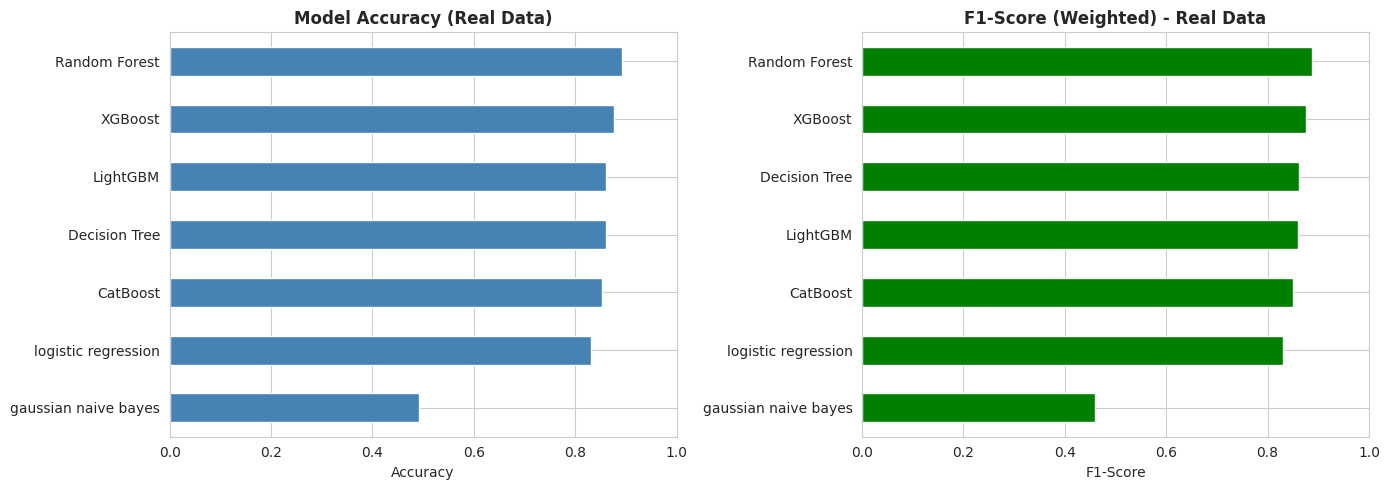

In [109]:
# visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# accuracy comparison
results_df['Accuracy'].sort_values(ascending=True).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Model Accuracy (Real Data)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Accuracy')
axes[0].set_xlim([0, 1])

# F1-Score comparison
results_df['F1 (Weighted)'].sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='green')
axes[1].set_title('F1-Score (Weighted) - Real Data', fontsize=12, fontweight='bold')
axes[1].set_xlabel('F1-Score')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

## 7. BEST MODEL ANALYSIS

In [110]:
# Best model
print(f"\n{best_model_name} ")

y_pred_best = results[best_model_name]
best_model = models[best_model_name]

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))


Random Forest 

Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.85      0.88        26
         Low       1.00      0.60      0.75        20
      Medium       0.87      0.98      0.92        84

    accuracy                           0.89       130
   macro avg       0.93      0.81      0.85       130
weighted avg       0.90      0.89      0.89       130




 confusion Matrix:
[[22  0  4]
 [ 0 12  8]
 [ 2  0 82]]


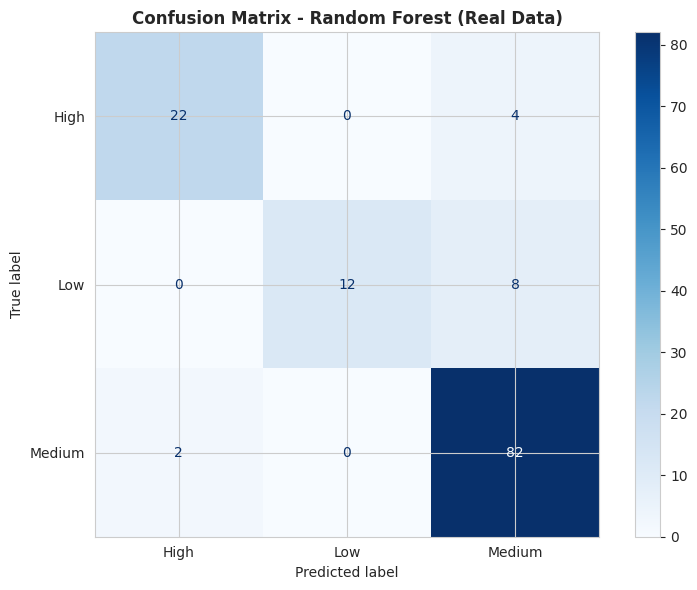

In [111]:
# confusion matrix
print(f"\n confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)

# visualize
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name} (Real Data)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


Top 10 Most Important Features:
  Feature  Importance
       G2    0.322423
       G1    0.203593
 failures    0.026971
      age    0.026217
   health    0.024270
 absences    0.023677
   famrel    0.023653
     Medu    0.023211
school_MS    0.022490
 freetime    0.022485


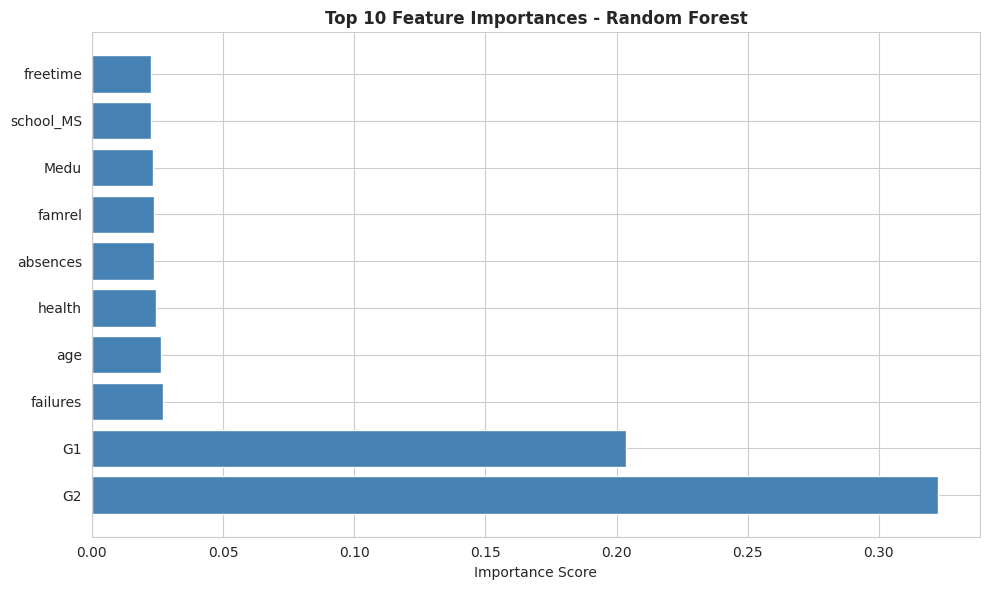

In [112]:
# feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), feature_importance['Importance'].head(10).values, color='steelblue')
    plt.yticks(range(10), feature_importance['Feature'].head(10).values)
    plt.xlabel('Importance Score')
    plt.title(f'Top 10 Feature Importances - {best_model_name}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. SAVE MODELS

In [113]:
# saving

os.makedirs('ml_models', exist_ok=True)

# save best model
model_path = f'ml_models/{best_model_name.replace(" ", "_")}_model.pkl'
joblib.dump(best_model, model_path)
print(f"best model: {model_path}")

# save scaler
scaler_path = 'ml_models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"scaler: {scaler_path}")

# save label encoder
encoder_path = 'ml_models/label_encoder.pkl'
joblib.dump(le, encoder_path)
print(f"label encoder: {encoder_path}")

# save feature names
features_path = 'ml_models/feature_names.pkl'
joblib.dump(X.columns.tolist(), features_path)
print(f"feature names: {features_path}")

# save all models
all_models_path = 'ml_models/all_models.pkl'
joblib.dump(models, all_models_path)
print(f"all models: {all_models_path}")

print(f"\n all artifacts saved!")
print(f" files in ml_models/: {os.listdir('ml_models')}")

best model: ml_models/Random_Forest_model.pkl
scaler: ml_models/scaler.pkl
label encoder: ml_models/label_encoder.pkl
feature names: ml_models/feature_names.pkl
all models: ml_models/all_models.pkl

 all artifacts saved!
 files in ml_models/: ['Random_Forest_model.pkl', 'Logistic_Regression_model.pkl', 'all_models.pkl', 'label_encoder.pkl', 'feature_names.pkl', 'scaler.pkl']


## 9. TEST SAVED MODEL

In [114]:
# Testing

# load artifacts
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_encoder = joblib.load(encoder_path)
loaded_features = joblib.load(features_path)

print("loaded")
# test on some samples
print("\n testing on real test samples:")
test_samples = X_test_scaled.head(5)

predictions = loaded_model.predict(test_samples)
predictions_proba = loaded_model.predict_proba(test_samples)

for i in range(len(test_samples)):
    actual = loaded_encoder.classes_[y_test[i]] # fix: Removed .values
    predicted = loaded_encoder.classes_[predictions[i]]
    confidence = predictions_proba[i].max()

    match = "ok" if actual == predicted else "error"
    print(f"\nsample {i+1}: {match}")
    print(f"  actual: {actual}")
    print(f"  predicted: {predicted}")
    print(f"  confidence: {confidence:.2%}")

loaded

 testing on real test samples:

sample 1: ok
  actual: Medium
  predicted: Medium
  confidence: 83.42%

sample 2: error
  actual: Low
  predicted: Medium
  confidence: 63.85%

sample 3: ok
  actual: Medium
  predicted: Medium
  confidence: 48.93%

sample 4: error
  actual: Low
  predicted: Medium
  confidence: 79.11%

sample 5: ok
  actual: Medium
  predicted: Medium
  confidence: 55.44%
